# Part 1


In [1]:
import torch

from utils import UNet_utils, ddpm_utils
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from utils import other_utils

In [2]:
import open_clip
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model.eval()
clip_tokenizer = open_clip.get_tokenizer('ViT-B-32')
CLIP_FEATURES = 512

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model.to(device)

model = UNet_utils.UNet(

    T=400, img_ch=3, img_size=32, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=512

).to(device)

model.load_state_dict(torch.load('05_clip_ddpm_flowers.pth'), strict=True) # You need to provide the path to your trained model

model.eval()

# TODO: Define a list of text prompts to generate images for.

text_prompts = [

    "A photo of a red rose",

    "A photo of a white daisy",

    "A photo of a yellow sunflower",
    
]

# --- Embedding Extraction using Hooks ---

# We will use PyTorch hooks to extract the output of the 'down2' layer (the bottleneck).

embeddings_storage = {}

def get_embedding_hook(name):
    def hook(model, input, output):
        embeddings_storage[name] = output.detach()
    return hook

# TODO: Register a forward hook on the `down2` layer of the U-Net model.

# The hook should store the output of the layer in the `embeddings_storage` dictionary.

model.down2.register_forward_hook(get_embedding_hook('down2'))

/tmp/ipykernel_15799/3326223877.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('05_clip_ddpm_flowers.pth'), strict=True) # You need to

Generating image for prompt: A photo of a red rose


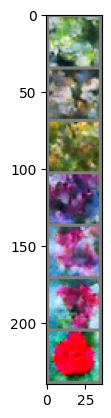

Generating image for prompt: A photo of a white daisy


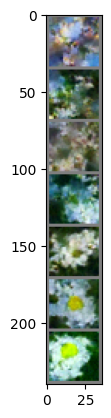

Generating image for prompt: A photo of a yellow sunflower


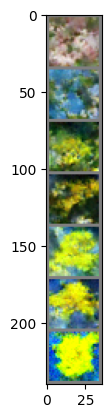

In [4]:
# TODO: Modify the `sample_flowers` function from notebook 05 to generate images 
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)
def sample_flowers(text_list):
    text_tokens = clip_tokenizer(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    grid = make_grid(x_gen.cpu(), nrow=len(text_list))
    other_utils.show_tensor_image([grid])
    plt.show()
    return x_gen, x_gen_store

# and store the extracted embeddings.

# You will need to run the generation process and then access the `embeddings_storage`

# to get the embeddings for each generated image.
for text_promt in text_prompts:
    print(f"Generating image for prompt: {text_promt}")
    generated_images, _ = sample_flowers([text_promt])
    for i, img in enumerate(generated_images):
        save_image(img, f"generated_images/generated_{text_promt.replace(' ', '_')}_{i}.png")

extracted_embeddings = embeddings_storage['down2']

# Part 2

In [5]:
import torch

import open_clip

from PIL import Image

def calculate_clip_score(image_path, text_prompt):

    # Load model

    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

    

    # Preprocess inputs

    image = preprocess(Image.open(image_path)).unsqueeze(0)

    tokenizer = open_clip.get_tokenizer('ViT-B-32')

    text = tokenizer([text_prompt])

    # Compute features and similarity

    with torch.no_grad():

        image_features = model.encode_image(image)

        text_features = model.encode_text(text)
        
        

        # Normalize features

        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_features /= text_features.norm(dim=-1, keepdim=True)

        

        # Calculate dot product

        score = (image_features @ text_features.T).item()

        

    return score




In [6]:
import numpy as np

from scipy.linalg import sqrtm

def calculate_fid(real_embeddings, gen_embeddings):

    # real_embeddings and gen_embeddings should be Numpy arrays of shape (N, 2048) 

    # extracted from an InceptionV3 model

    

    # Calculate mean and covariance

    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings,
                                                       rowvar=False)

    mu2, sigma2 = gen_embeddings.mean(axis=0), np.cov(gen_embeddings, rowvar=False)

    # Calculate sum squared difference between means

    ssdiff = np.sum((mu1 - mu2)**2)

    # Calculate sqrt of product of covariances

    covmean = sqrtm(sigma1.dot(sigma2))

    

    # Handle numerical errors

    if np.iscomplexobj(covmean):

        covmean = covmean.real

    # Final FID calculation

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [7]:
import torch.nn as nn
from torchvision.models import inception_v3, Inception_V3_Weights
import torchvision.transforms.v2 as transforms

inception_preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

inception = inception_v3(weights=Inception_V3_Weights.DEFAULT).to(device)
inception.fc = nn.Identity()  # Replace classifier with passthrough
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [8]:
sample_img_paths = []
sample_promts = []
sample_embeddings = []
sample_clip_scores = []

In [9]:
# for i, prompt in enumerate(text_prompts):
#     for j in range(7):
#         image_path = f"generated_images/generated_{prompt.replace(' ', '_')}_{j}.png"
#         clip_score = calculate_clip_score(image_path, prompt)
#         embedding = extracted_embeddings[i*7 + j].unsqueeze(0).cpu().numpy()
#         print(embedding.shape)
#         sample_clip_scores.append(clip_score)
#         sample_img_paths.append(image_path)
#         sample_promts.append(prompt)
#         sample_embeddings.append(embedding)
#         print(f"CLIP score for prompt '{prompt}': {clip_score}, FID: {"fid"}")

## calculate fid

In [10]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs).float()
    return clip_img_encodings

100%|██████████| 12/12 [00:00<00:00, 17.43it/s]
0it [00:00, ?it/s]

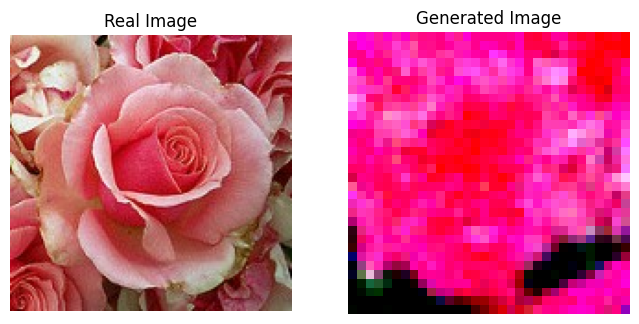

1it [00:34, 34.79s/it]

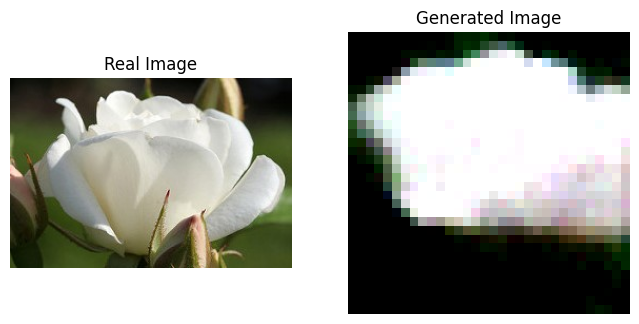

2it [01:10, 35.06s/it]

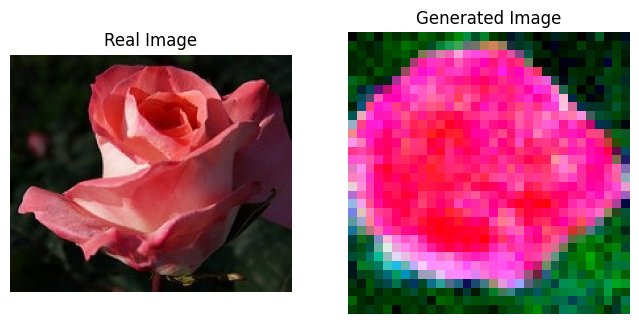

3it [01:45, 35.12s/it]

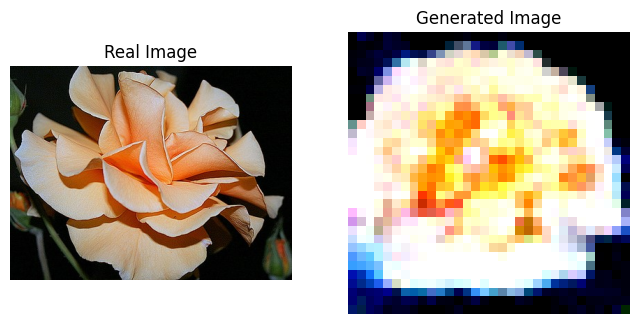

4it [02:20, 35.19s/it]

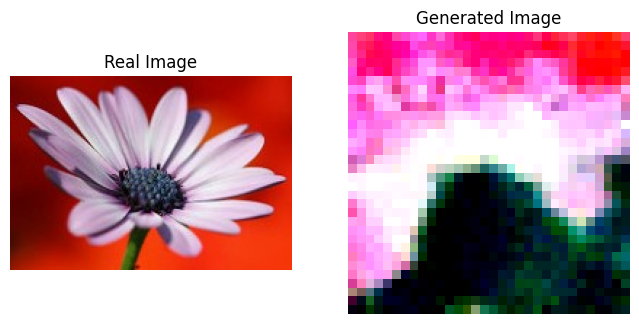

5it [02:55, 35.24s/it]

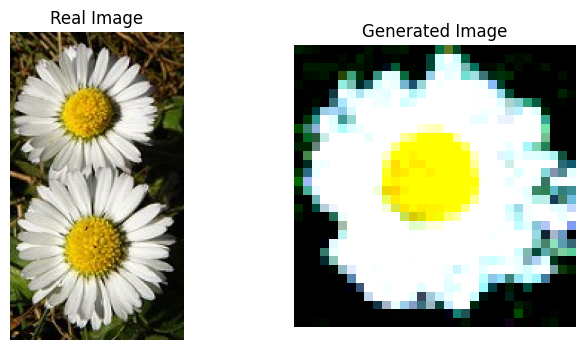

6it [03:31, 35.28s/it]

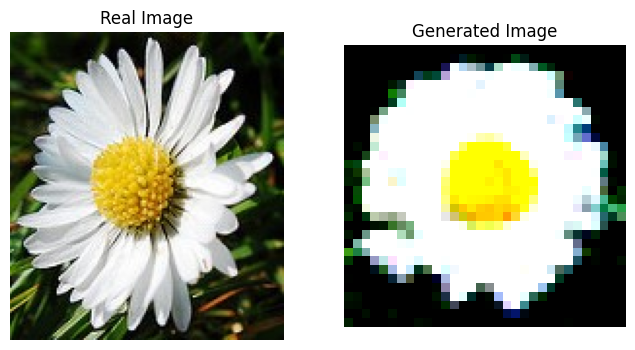

7it [04:06, 35.28s/it]

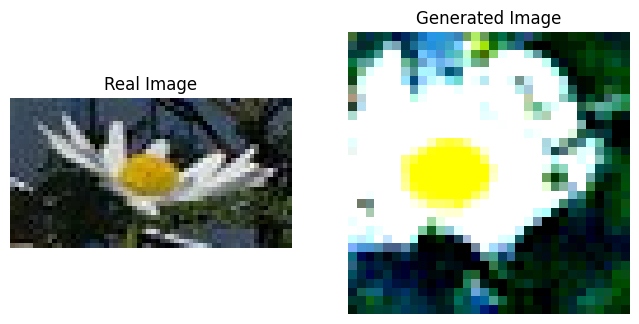

8it [04:41, 35.26s/it]

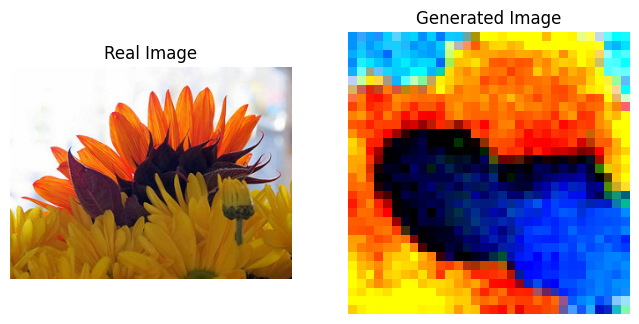

9it [05:17, 35.29s/it]

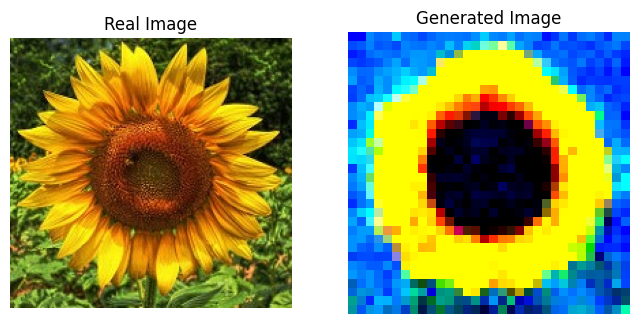

10it [05:52, 35.33s/it]

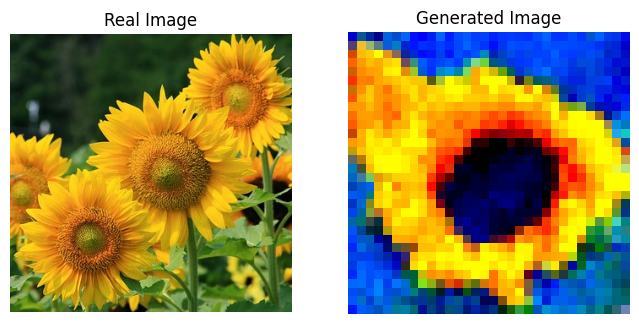

11it [06:28, 35.52s/it]

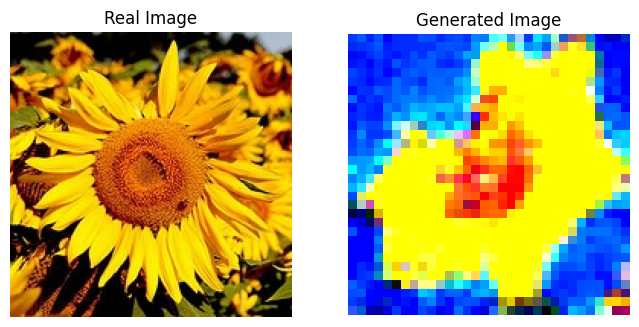

12it [07:04, 35.38s/it]


In [ ]:
import os
from tqdm import tqdm
roses_path = "data/cropped_flowers/roses"
daisies_path = "data/cropped_flowers/daisy"
sunflowers_path = "data/cropped_flowers/sunflowers"

roses = [os.path.join(roses_path, f) for f in os.listdir(roses_path) if f.endswith('.jpg')]
daisies = [os.path.join(daisies_path, f) for f in os.listdir(daisies_path) if f.endswith('.jpg')]
sunflowers = [os.path.join(sunflowers_path, f) for f in os.listdir(sunflowers_path) if f.endswith('.jpg')]

real_img_paths = roses[:10] + daisies[:10] + sunflowers[:10]
real_embeddings = []
clip_encodings = []
for img_path in tqdm(real_img_paths):
    image = Image.open(img_path).convert('RGB')
    image_tensor = inception_preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = inception(image_tensor).cpu().numpy()
        real_embeddings.append(embedding)
        clip_encoding = get_img_encodings([image])
        clip_encodings.append(clip_encoding)
generated_embeddings = []
for enc, real in tqdm(zip(clip_encodings, real_img_paths)):
    enc = enc.to(device)
    x_gen, _ = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, enc, device)
    img = x_gen[-1]
    img = other_utils.to_image(img)
    # plot real img vs generated images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Real Image")
    plt.imshow(Image.open(real).convert('RGB'))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Generated Image")
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    image_tensor = inception_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = inception(image_tensor).cpu().numpy()
        generated_embeddings.append(embedding)


In [15]:
# Stack all embeddings into proper arrays
real_embeddings_array = np.vstack(real_embeddings)
generated_embeddings_array = np.vstack(generated_embeddings)

# Calculate FID on the entire set
fid = calculate_fid(real_embeddings_array, generated_embeddings_array)
print(f"FID Score: {fid:.4f}")
print(f"Calculated on {len(real_embeddings)} real and {len(generated_embeddings)} generated images")

FID Score: 364.1212
Calculated on 12 real and 12 generated images
